# Miara odległości napisów

Zadanie dotyczy różnych metryk w przestrzeni napisów.

1. Zaimplementuj przynajmniej 3 "metryki" spośród wymienionych: cosinusowa, LCS, DICE, euklidesowa, Levenshteina.
2. Zaimplementuj przynajmniej 1 sposoby oceny jakości klasteryzacji (np. indeks Daviesa-Bouldina).
3. Stwórz stoplistę najczęściej występujących słów i zastosuj ją jako pre-processing dla nazw. Algorytmy klasteryzacji powinny działać na dwóch wariantach: z pre-processingiem i bez pre-processingu.
4. Wykonaj klasteryzację zawartości załączonego pliku (lines.txt) przy użyciu  metryk zaimplementowanych w pkt. 1. Każda linia to adres pocztowy firmy, różne sposoby zapisu tego samego adresu powinny się znaleźć w jednym klastrze.
5. Porównaj jakość wyników sposobami zaimplementowanymi w pkt. 2.
6. Czy masz jakiś pomysł na poprawę jakości klasteryzacji w tym zadaniu?

Sprawozdanie powinno zawierać porównanie wyników wszystkich metryk z użyciem stoplisty i bez.

Można jako wzorcową klasteryzację użyć pliku clusters.txt.

In [1]:
import numpy as np
from math import sqrt
from math import inf
import string
from collections import Counter
import pandas as pd
from scipy.cluster.hierarchy import fclusterdata

## ad 1. Metryki

### Cosine similarity

$$
\begin{equation}
    \cos(\theta) = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}= \frac{\sum\limits_{i=1}^{n} A_i B_i}{\sqrt{\sum\limits_{i=1}^{n} A_i^2} \sqrt{\sum\limits_{i=1}^{n} B_i^2}}
    \qquad\begin{aligned}
    &\text{gdzie:} \\
    &\mathbf{A}\text{ oraz }\mathbf{B} \text{ to dwa porównywane wektory}\\
    &n \text{ to wymiar wektorów}\\
    &\theta \text{ to kąt między wektorami } \mathbf{A} \text{ oraz } \mathbf{B} \text{ w wielowymiarowej przestrzeni}
    \end{aligned}
\end{equation}
$$

In [2]:
def cosine_sim(A, B):
    return np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B))

### Sørensen–Dice coefficient

$$
\begin{equation}
    \text{Dice}(A, B) = \frac{2 |A \cap B|}{|A| + |B|} 
    \qquad\begin{aligned}
    &\text{gdzie:} \\
    &A \text{ oraz } B \text{ to dwa zbiory, które są porównywane} \\
    &|A| \text{ oraz } |B| \text{ to liczności zbiorów } \\
    &\text{oraz } |A \cap B| \text{ to liczność iloczynu zbiorów}
    \end{aligned}
\end{equation}
$$


In [3]:
def dice_coef(A, B):
    intersec=0
    norm_a=0
    norm_b=0
    N=len(A)
    for i in range(N):
        if A[i]!=0 and B[i]!=0: intersec+=1
        if A[i]!=0: norm_a+=1
        if B[i]!=0: norm_b+=1
    return intersec*2/(norm_a+norm_b)

### Euclidean distance

$$
\begin{equation}
    d(x,y) = \sqrt{\sum_{i=1}^{n}(x_i-y_i)^2}
    \qquad\begin{aligned}
    &\text{gdzie:} \\
    &d(x,y) \text{ to odległość euklidesowa} \\
    &x_i, y_i \text{ to i-te współrzędne wektorów } x \text{ oraz } y \\
    &n \text{ to liczba wymiarów wektorów}
    \end{aligned}
\end{equation}
$$

In [4]:
def euclidean_dist(A,B):
    result=0
    for i in range (len(A)):
        result+=(A[i]-B[i])**2
    return sqrt(result)

## ad 2. Ocena jakości klasteryzacji

### Davies–Bouldin index (DBI)

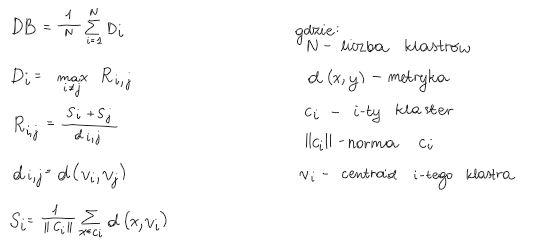

In [5]:
def centroid(cluster, metric):
    distances = [0 for _ in range(len(cluster))]
    for i in range(len(cluster)):
        for j in range(i):
            dist = metric(cluster[i], cluster[j])
            distances[i] += dist
            distances[j] += dist
    min_dist = -inf
    index = -1
    for i in range(len(distances)):
        if distances[i] < min_dist:
            min_dist = distances[i]
            index = i
    return cluster[index]

def intra_cluster_dispersion(cluster, metric, centroid):
    res=0
    for i in cluster:
        res+=metric(i, centroid)
    return res/np.linalg.norm(cluster)

In [6]:
def dbi(clusters, metric):
    N=len(clusters)
    centroids=[centroid(clusters[i], metric) for i in range (N)]
    S=[intra_cluster_dispersion(clusters[i], metric, centroids[i]) for i in range (N)]
    R=[[0 for i in range (N)] for j in range (N)]
    for i in range (N):
        for j in range (N):
            if i!=j:
                R[i][j]=(S[i]+S[j])/metric(centroids[i], centroids[j])
    sum_D=0
    for i in range(N):
        a=0
        if i>0: a=max(R[i][:i])
        b=0
        if i<N-1: b=max(R[i][i+1:])
        sum_D+=max(a,b)
    return sum_D/N

## ad 3. Stoplista

In [7]:
def stoplist(text, freq):
    words=[]
    for line in text:
        words+=line.split()
    cnt=Counter(words)
    stopl={key for key, val in cnt.items() if val>=freq*len(words)}
    return stopl

def rem_stoplist(text, stoplist):
    res=[]
    for line in text:
        res.append("".join([w for w in line.split() if w not in stoplist]))
    return res

def rem_common(text, freq):
    return rem_stoplist(text, stoplist(text, freq))

## Preprocessing

In [8]:
def read_text(file):
    with open(file, "r", encoding="UTF-8") as f:
        text = f.read()
    return text

def preprocess(text, stoplist_freq=None):
    preprocessed=text.translate(str.maketrans('', '', string.punctuation)).lower()
        
    cnt=Counter()
    cnt.update(preprocessed)
    vocab=list(cnt)
    
    preprocessed=preprocessed.splitlines()
    
    if stoplist_freq!=None:
         preprocessed=rem_common(preprocessed, stoplist_freq)
            
    return preprocessed, vocab

def text_to_vec(text, stoplist_freq=None):
    text, vocab=preprocess(text, stoplist_freq)
    freq_vec=[]
    for line in text:
        cnt=Counter()
        cnt.update(line)
        el=[cnt[letter] for letter in vocab]
        freq_vec.append(el)
    return freq_vec, text

## ad 4. Klasteryzacja

In [9]:
def cluster(vec_text, metric, text=None):        
    T=fclusterdata(vec_text, t=1, metric=metric)
    clusters=[[] for i in range (max(T))]
    text_clusters=None
    if text!=None:
        text_clusters=[[] for i in range (max(T))]
    for i in range (len(T)):
        clusters[T[i]-1].append(vec_text[i])
        if text!=None:
            text_clusters[T[i]-1].append(text[i])
    return clusters, text_clusters

In [10]:
text=read_text("lines.txt")
vec_text_0, lines_0=text_to_vec(text)
vec_text_02, lines_02=text_to_vec(text,0.2)
vec_text_05, lines_05=text_to_vec(text,0.5)

In [11]:
cl=cluster(vec_text_0[:100], euclidean_dist, lines_0[:100])[1]
for i in cl:
    for j in i:
        print(j)
    print("---------")

express co ltd russia 155101 ivanovskaya region lezhnevskiy raion d koroviha centralnaya str 4arussia
express co ltd  russia 155101 ivanovskaya region lezhnevskiy raion d koroviha centralnaya str 4arussia
---------
alliancetrade llc inn 7816391055  kpp 784601001 190020 saint petersburg quay of the obvodny channel 138 bulk 1 literb
avanport  llc inn 7839413675 kpp 783901001 190020 saint petersburg quay of the obvodny channel 134136138 build 101 lit a
avanport  llc inn 7839413675 kpp 783901001 190020 saint petersburg quay of  the obvodny channel134136138  build 101 lit a
prant llc 603159 russia nizhny novgorod akimovastr 41 suite 63 inn 5257120394 kpp 525701001 telfax 7 831 4234533
---------
ltc solution oy finland hamina 49420 pilaritie 2 tel 358 0 52266130 fax 358 0 52266120
ltc solution oy finland hamina 49420 syvasatamantie 18 tel 358 0 52266130 fax 358 0 52266120
---------
sevrollsystem spz oo plac czerwca 1976 roku nr 1b  02495 warszawa ursus  tel 022 3123139
sevrollsystem spz oo p

In [12]:
cl0_e=cluster(vec_text_0[:1000], euclidean_dist)[0]
cl0_d=cluster(vec_text_0[:1000], dice_coef)[0]
cl0_c=cluster(vec_text_0[:1000], cosine_sim)[0]

In [13]:
cl02_e=cluster(vec_text_02[:1000], euclidean_dist)[0]
cl02_d=cluster(vec_text_02[:1000], dice_coef)[0]
cl02_c=cluster(vec_text_02[:1000], cosine_sim)[0]

In [14]:
cl05_e=cluster(vec_text_05[:1000], euclidean_dist)[0]
cl05_d=cluster(vec_text_05[:1000], dice_coef)[0]
cl05_c=cluster(vec_text_05[:1000], cosine_sim)[0]

## ad 5. Porównanie jakości wyników

In [15]:
dbi_e={"no stoplist": dbi(cl0_e, euclidean_dist),
       "0.2 stoplist": dbi(cl02_e, euclidean_dist),
       "0.5 stoplist": dbi(cl05_e, euclidean_dist)}
dbi_d={"no stoplist": dbi(cl0_d, dice_coef),
       "0.2 stoplist": dbi(cl02_d, dice_coef),
       "0.5 stoplist": dbi(cl05_d, dice_coef)}
dbi_c={"no stoplist": dbi(cl0_c, cosine_sim),
       "0.2 stoplist": dbi(cl02_c, cosine_sim),
       "0.5 stoplist": dbi(cl05_c, cosine_sim)}
dbis={"Euclidean distance": dbi_e,
       "Sørensen–Dice coefficient": dbi_d,
       "Cosine similarity": dbi_c}

In [16]:
data_frame=pd.DataFrame(dbis)
print("Davies–Bouldin index")
display(data_frame)

Davies–Bouldin index


,Euclidean distance,Sørensen–Dice coefficient,Cosine similarity
no stoplist,0.198899,0.000000,0.0
0.2 stoplist,0.277106,1.306997,0.0
0.5 stoplist,0.277106,1.306997,0.0


In [17]:
len_e={"no stoplist": len(cl0_e),
       "0.2 stoplist": len(cl02_e),
       "0.5 stoplist": len(cl05_e)}
len_d={"no stoplist": len(cl0_d),
       "0.2 stoplist": len(cl02_d),
       "0.5 stoplist": len(cl05_d)}
len_c={"no stoplist": len(cl0_c),
       "0.2 stoplist": len(cl02_c),
       "0.5 stoplist": len(cl05_c)}
lens={"Euclidean distance": len_e,
       "Sørensen–Dice coefficient": len_d,
       "Cosine similarity": len_c}

In [18]:
data_frame1=pd.DataFrame(lens)
print("Clusters' size")
display(data_frame1)

Clusters' size


,Euclidean distance,Sørensen–Dice coefficient,Cosine similarity
no stoplist,526,1,1
0.2 stoplist,501,430,1
0.5 stoplist,501,430,1


Z uwagi na duże dane wejściowe i długi czas oczekiwania na ich przetworzenie przeprowadzono analizę jedynie dla 1000 pierwszych wierszy.
Wnioski:
1. Zmiana parametru częstości stoplisty z 0.2 na 0.5 nie wpłynęła na wynik.
2. Zastosowanie stoplisty dobrze wpłynęło na jakość otrzymanej klasteryzacji w przetestowanych przypadkach.
3. Metryka jaką jest podobieństwo cosinusowe nie sprawdziła się w klasteryzacji dla przetestowanych danych.

## ad 6. Poprawa jakości klasteryzacji

1. Odpowiednie dopasowanie parametrów\
Aby poprawić klasteryzację można zastosować różne metody (np. uczenie maszynowe) aby dobrać najlepsze parametry - np. częstość do stworzenia stoplisty lub parametry dla wykorzystanej funkcji fclusterdata z biblioteki scipy.
2. Dobranie optymalnej metryki\
Dobranie metryki powinno zostać zrealizowane na podstawie specyfiki danych wejściowych.